# del: Mini Challenge 1 with CIFAR-10 Dataset
- **Author**: Nils Fahrni
- **Submission Date**: 18.04.2024

In [2]:
%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "del_mc1"

import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torcheval.metrics import MulticlassAccuracy
from sklearn.model_selection import KFold
from config import default_config
import torch.optim as optim
import numpy as np

import wandb

env: WANDB_SILENT=True
env: "WANDB_NOTEBOOK_NAME"="del_mc1"


#### Downloading Dataset
In order to work with the CIFAR10 Dataset, the dataset can be downloaded via the `torchvision` package. An important note at this step is that the CIFAR10 images are not normalized or standardized in any way at the point after downloading it. To later on learn the classes of the dataset it first is normalized on the metrics of the trainset.

In [3]:
unnormalized_transform = transforms.Compose([
    transforms.ToTensor()
])

unnormalized_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=unnormalized_transform)

def calculate_mean_std(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in dataloader:
        for i in range(3):
            mean[i] += images[:,i,:,:].mean()
            std[i] += images[:,i,:,:].std()
    mean.div_(len(dataloader))
    std.div_(len(dataloader))
    return mean, std

mean, std = calculate_mean_std(unnormalized_trainset)
print("Mean: ", mean)
print("Std: ", std)

normalized_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy())
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=normalized_transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalized_transform)

Files already downloaded and verified
Mean:  tensor([0.4915, 0.4822, 0.4466])
Std:  tensor([0.2463, 0.2428, 0.2607])
Files already downloaded and verified
Files already downloaded and verified


#### Taking a look at the classes
To gain a grasp of how the data at hand looks, this following cell will plot the possible classes each with a random example from `CIFAR-10`.

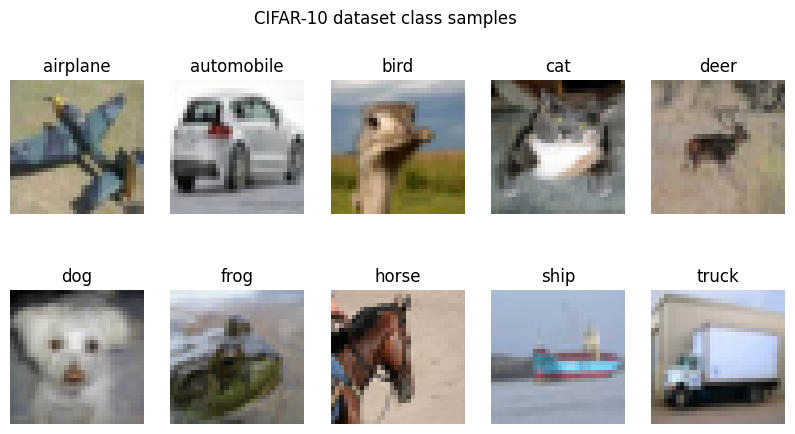

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('CIFAR-10 dataset class samples')

independent_class_images = dict()

while len(independent_class_images) < 10:
    index = np.random.randint(0, len(cifar_trainset))
    image, label = cifar_trainset[index]
    if label not in independent_class_images:
        independent_class_images[label] = image

def reverse_normalize(tensor_img, mean, std):
    mean = mean.numpy()
    std = std.numpy()

    rev_img = tensor_img.numpy().transpose((1, 2, 0))
    rev_img = rev_img * std + mean
    rev_img = np.clip(rev_img, 0, 1)
    return rev_img

idx = 0
for i in range(2):
    for j in range(5):
        if idx in independent_class_images:
            img_to_plot = reverse_normalize(independent_class_images[idx], mean, std)
            axs[i, j].imshow(img_to_plot)
            axs[i, j].set_title(cifar_trainset.classes[idx])
            axs[i, j].axis('off')
        idx += 1

plt.show()

An observation at this point is the small size and low resolution of the images. This fact could limit the models' ability to capture small and intricate details which are certainly needed for accurate classification. I could imagine that the dataset proposes a rather hard task because some of the images for example depict logos or illustrations while others represnt an actual photograph of the object (class).

#### Color space distribution

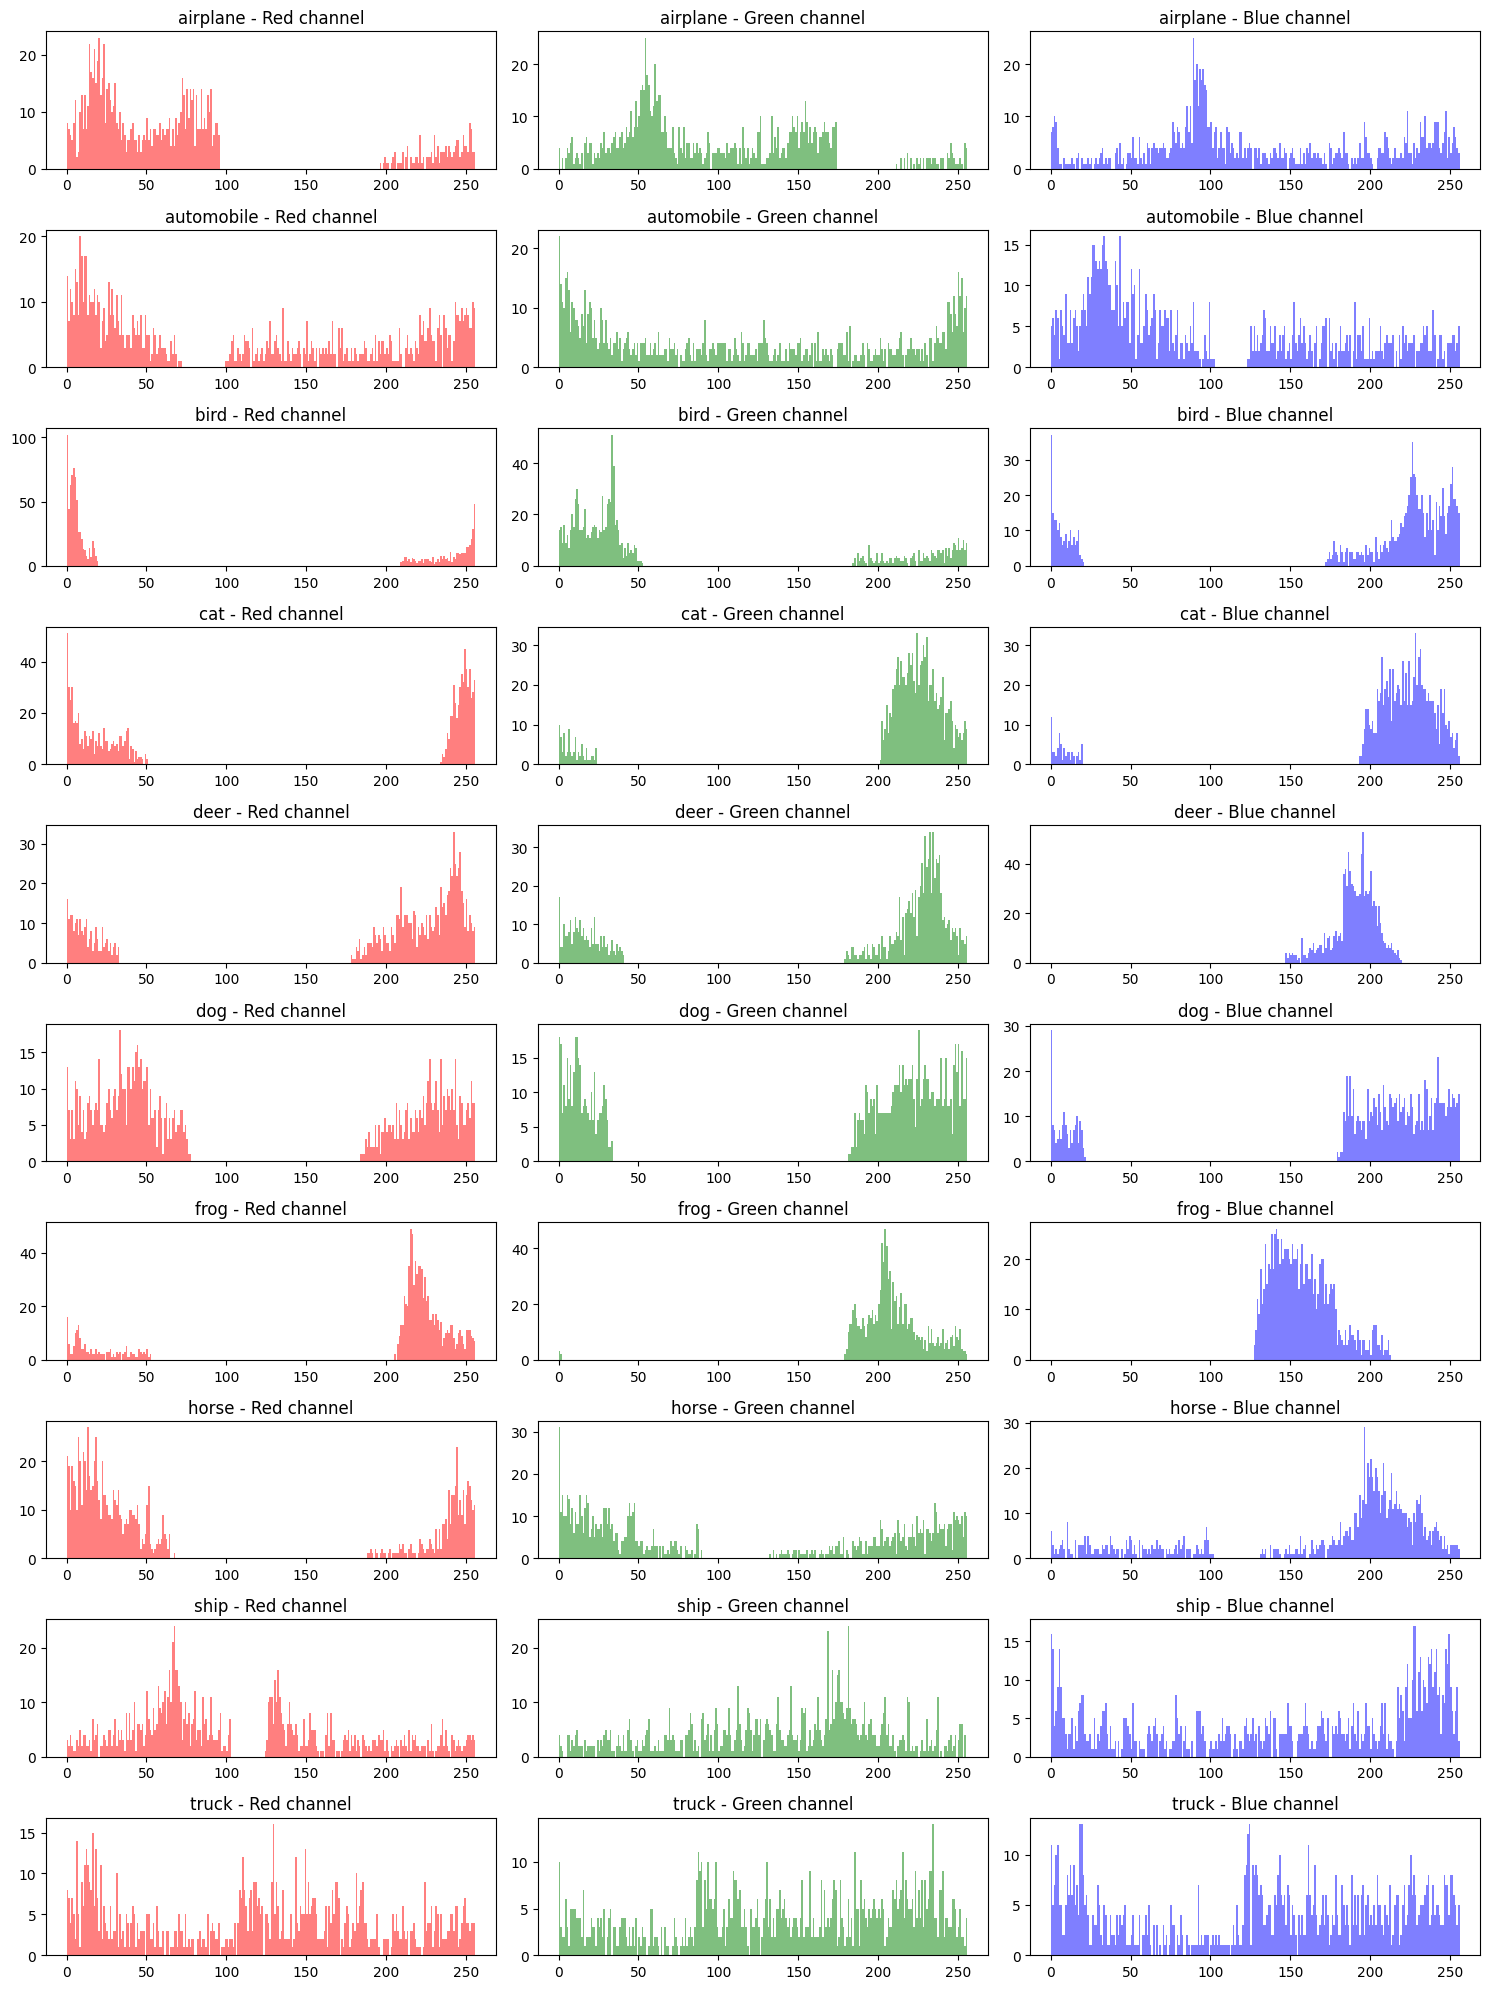

In [5]:
def compute_average_images(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    sum_images = [torch.zeros(3, 32, 32) for _ in range(10)]
    count_images = [0] * 10

    for images, labels in dataloader:
        for image, label in zip(images, labels):
            sum_images[label] += image
            count_images[label] += 1

    avg_images = [sum_images[i] / count_images[i] for i in range(10)]
    return avg_images

avg_images = compute_average_images(cifar_trainset)

fig, axs = plt.subplots(10, 3, figsize=(15, 20))
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, avg_image in enumerate(avg_images):
    for j in range(3):
        scaled_image = (avg_image[j].numpy().ravel() * 255).astype(np.uint8)
        axs[i, j].hist(scaled_image, bins=256, color=['red', 'green', 'blue'][j], alpha=0.5, range=(0, 256))
        axs[i, j].set_title(f'{class_labels[i]} - {["Red", "Green", "Blue"][j]} channel')

plt.tight_layout()
plt.show()

The bird, deer, dog, and cat classes show a high concentration of pixel values at both the low and high ends of the RGB channels, with noticeable gaps in the middle, reflecting their natural coloring and varied textures. Notably, birds have a distinct tail in the high end of the blue channel, indicating a higher proportion of blue pixels, but fewer in the red and green channels compared to other animals, which tend to have a more balanced distribution across all colors. In contrast, classes like airplanes, ships, trucks, and automobiles have more evenly distributed color channels, likely due to uniform lighting, smoother surfaces, and the presence of large areas with consistent color tones like sky, road, or water. This leads to more gradual transitions in their RGB distributions.

#### Class Distribution

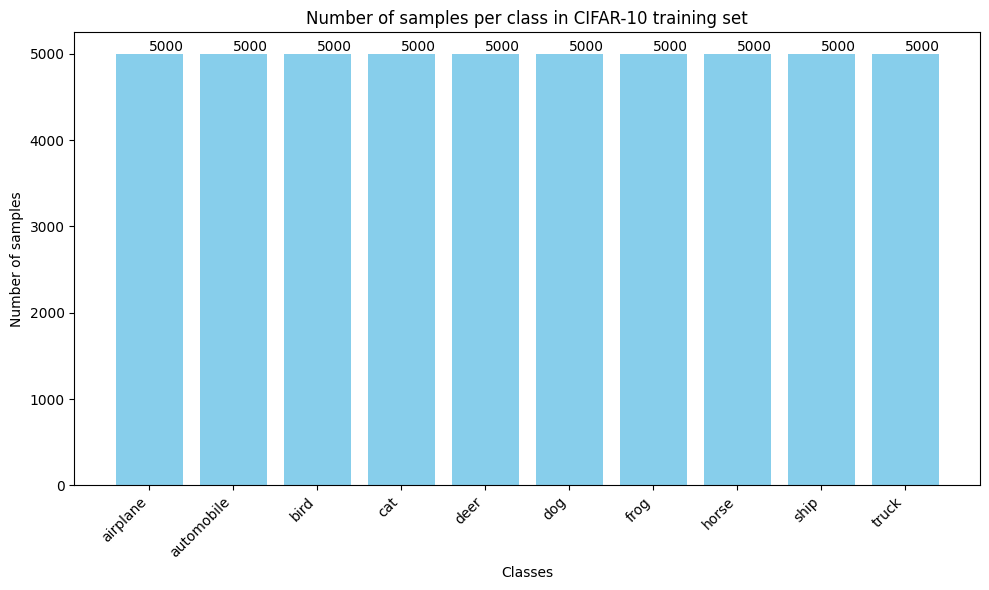

In [6]:
from collections import Counter
class_counts = Counter(target for _, target in cifar_trainset)

class_names = cifar_trainset.classes

classes = range(len(class_names))
counts = [class_counts[i] for i in classes]

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class in CIFAR-10 training set')
plt.xticks(classes, class_names, rotation=45, ha="right")

plt.tight_layout()
plt.show()


The class distribution shows that the `CIFAR-10` dataset already is perfectly even distributed. No considerations therefore regarding a class imbalance must be made.

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Base Functions

### Train Method
The `train`-function takes a PyTorch model and other parameters to train it using the specified dataset (`data_loader`). It computes the loss using the given criterion, updates the model's weights using the optimizer, and calculates the training accuracy for multiclass classification. Periodically, based on the verbose_interval, it prints the average loss for that interval if verbose is set to True. Finally, it returns a dictionary containing the training accuracy and average loss over the entire dataset for the epoch.

In [8]:
def train(model: nn.Module, 
          optimizer, 
          criterion, 
          data_loader: torch.utils.data.DataLoader, 
          device,
          n_classes: int,
          verbose=True, verbose_interval=2000,
          current_epoch: int =1):
    acc = MulticlassAccuracy(num_classes=n_classes, device=device)

    running_loss = 0.0
    verbose_loss = 0.0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        class_pred = outputs.argmax(dim=1)
        acc.update(class_pred, labels)

        running_loss += loss.item()
        verbose_loss += loss.item()
        
        if verbose and i % verbose_interval == verbose_interval - 1:
            print(f'[Epoch {current_epoch}, {i + 1}] loss: {verbose_loss / verbose_interval:.3f}')
            verbose_loss = 0.0
    
    train_loss = running_loss / len(data_loader)

    return {"train_accuracy": acc.compute(), "train_loss": train_loss}

#### Test Method
The `test`-function on the other hand evaluates a PyTorch model's performance based on the test-set (`data_loader`). It calculates the test loss using the provided criterion and measures the accuracy of the model's predictions against true labels for multiclass classification, without updating the model's weights. The model is set to evaluation mode (model.eval()) to disable operations like dropout. It returns a dictionary containing the computed test accuracy and the average loss over the entire dataset.

In [9]:
def test(model: nn.Module,
         criterion,
         data_loader: torch.utils.data.DataLoader,
         device,
         n_classes: int
         ):
    accuracy = MulticlassAccuracy(num_classes=n_classes, device=device)
    
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data, target = data.view(-1, 3, 32, 32), target
            y_true.append(target)

            output = model(data)
            y_pred.append(output)

            test_loss += criterion(output, target).item()

            class_pred = output.argmax(dim=1)
            accuracy.update(class_pred, target)
    
    test_loss /= len(data_loader)

    return { "test_accuracy": accuracy.compute(), "test_loss": test_loss}

#### Model Training/Testing Orchestration
Lastly the `run_model_experiment`-function orchestrates the training and testing of a model across multiple epochs, using specified training and testing data loaders. If no optimizer is provided, it defaults to using SGD with a specified learning rate. The function allows for configurable weight initialization methods before training begins. During training, it integrates with Weights & Biases (wandb) for experiment tracking, logging both training and testing metrics per epoch. Optionally, it can monitor the model's gradients and parameters closely if watch is enabled. At the end of training, the function provides a link to the Weights & Biases project page for detailed visualization and analysis of the run.

In [10]:
def run_model_experiment(model: nn.Module, 
                 criterion, 
                 optimizer,
                 train_loader: torch.utils.data.DataLoader,
                 test_loader: torch.utils.data.DataLoader,
                 config=default_config,
                 weight_init: str = 'kaiming',
                 learning_rate: float = 0.01,
                 n_epochs: int = 10,
                 n_classes: int = 10,
                 run_name: str = None,
                 tags: list[str] = None,
                 verbose: bool = False,
                 watch: bool = False
                ):
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            if weight_init == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight)
            elif weight_init == 'xavier':
                torch.nn.init.xavier_normal_(m.weight)
            elif weight_init == 'normal':
                mean = m.weight.mean().item()
                std = m.weight.std().item()
                torch.nn.init.normal_(m.weight, mean, std)
            else:
                raise ValueError(f"Unknown weight initialization method: {weight_init}")

    with wandb.init(project="del-mc1", 
                    name=run_name if run_name is not None else model.__class__.__name__, 
                    config=default_config,
                    tags=tags if tags is not None else None,
                    settings=wandb.Settings(disable_job_creation=True)
                    ) as run:
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        model.to(device)

        print(f"--- Model Architecture ---")
        print(model, '\n')

        print(f"--- Running Experiment {run_name} ---")
        torch.manual_seed(config["seed"]) 

        if watch:
            wandb.watch(model, criterion=criterion, log="all", log_graph=True, log_freq=1)
        for epoch in range(1, n_epochs + 1):
            train_metrics = train(model, optimizer, criterion, train_loader, device, n_classes, current_epoch=epoch, verbose=verbose)
            test_metrics = test(model, criterion, test_loader, device, n_classes)
            wandb.log({**train_metrics, **test_metrics, "epoch": epoch})
            print(f"Epoch {epoch} - Train accuracy: {train_metrics['train_accuracy']:.3f}, Test accuracy: {test_metrics['test_accuracy']:.3f}")
        if watch:
            wandb.unwatch(model)
        print(f"View run at: https://wandb.ai/{run.entity}/{run.project}/{run.id}")
        print()


In [11]:
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True, num_workers=4) 
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False, num_workers=4)

## Base Model
The Baseline Model `BaseCNN` is being used to go through every experiment. It's a simple CNN model which has been held rather shallow for efficiency's sake. The goal during the following analyses will be to measure and see the impact different hyperparameters and related settings have. The effects of those analyses should also be measurable within such a simplistic model.

The model consists of the following architecture:
1. **Convolutional Layers**: 
    - The model starts with two convolutional layers that extract spatial hierarchies of features from the input image. The first convolutional layer transforms the 3-channel RGB image (`32x32x3`) into `32` feature maps, applying a `3x3` kernel with padding to preserve the spatial dimensions.
    - The second convolutional layer increases the number of feature maps to `64` while maintaining the same kernel size and padding strategy. These convolutional layers learn local patterns such as edges, textures, and shapes in the image.

2. **Non-linear Activation (ReLU)**:
    - After each convolutional layer, a ReLU (Rectified Linear Unit) activation function is applied to introduce non-linearity.

3. **Pooling Layers**:
    - Each convolutional block is followed by a `MaxPooling` layer with a `2x2` kernel, which reduces the spatial dimensions by a factor of 2 (`32x32` to `16x16`, and then `16x16` to `8x8`). This helps reduce the computational cost and also somewhat helps to mitigate overfitting by downsampling the feature maps.

4. **Latent Space Representation**:
    - After the convolutional and pooling operations, the `8x8x64` feature maps are flattened into a 1D vector of size `64 * 8 * 8` (`4096`). This vector is a compressed representation of the input image, often referred to as the latent space. The latent space captures the high-level features learned by the convolutional layers, which are then passed to the fully connected layers for classification.

5. **Fully Connected Layers**:
    - The fully connected layers (Linear layers) follow the flattened latent space. The first fully connected layer reduces the feature vector size from `4096` to `512`, the second layer further reduces it to `128`, and the final output layer reduces it to `10`. The number `10` corresponds to the number of classes (e.g., for CIFAR-10).

6. **Output Layer**:
    - The final layer produces `10` output neurons, representing the class logits for the `10` classes. These logits can later be passed through a softmax activation to generate class probabilities during inference.

In [12]:
def BaseCNN():
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),

        nn.Linear(64 * 8 * 8, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

### Customizable Base Model
For the following experiments and analyses, this following function will help to configure new models based on the `BaseCNN`. The `CustomBaseCNN` method helps to extend the `BaseCNN` in a fast manner so that experiments can be executed fast and debugged fast while offering the same base for all analyses so there is a common ground for comparison.

In [17]:
def CustomBaseCNN(filters_per_layer=[32, 64], 
                  kernel_sizes=[3, 3], 
                  strides=[1, 1],
                  paddings=[1, 1], 
                  maxpool_sizes=[(2, 2), (2, 2)],
                  fc_sizes=[512, 128, 10],
                  use_dropout=False,
                  dropout_rate=0.5,
                  use_batchnorm=False,
                  batchnorm_momentum=0.1):
    layers = []

    num_conv_layers = len(filters_per_layer)
    num_fc_layers = len(fc_sizes)

    input_channels = 3
    output_size = 32
    
    for i in range(num_conv_layers):
        layers.append(nn.Conv2d(input_channels, filters_per_layer[i], kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i]))
        
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(filters_per_layer[i], momentum=batchnorm_momentum))
        
        layers.append(nn.ReLU())
        
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        if maxpool_sizes[i] is not None:
            layers.append(nn.MaxPool2d(maxpool_sizes[i]))
            output_size = (output_size - kernel_sizes[i] + 2*paddings[i]) // strides[i] + 1
            output_size = output_size // maxpool_sizes[i][0]

        input_channels = filters_per_layer[i]

    layers.append(nn.Flatten())

    input_size = input_channels * output_size * output_size

    for i in range(num_fc_layers):
        layers.append(nn.Linear(input_size, fc_sizes[i]))
        
        if i < num_fc_layers - 1:
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(fc_sizes[i], momentum=batchnorm_momentum))
            layers.append(nn.ReLU())
            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))
            input_size = fc_sizes[i]

    return nn.Sequential(*layers)


## Overfit Testing
The first exploration done in the Mini Challenge aims to validate the Baseline Model by only propagating and learning a single example. This will show if the model is capable of learning and therefore the expected outcome is that it will show fast convergence and immediate perfect fit (Overfit).

In [62]:
subsample_subset = torch.utils.data.Subset(cifar_trainset, list(range(16)))
subsample_loader = torch.utils.data.DataLoader(subsample_subset, batch_size=16, shuffle=False)

run_model_experiment(BaseCNN(), 
             nn.CrossEntropyLoss(),
             None, 
             subsample_loader, 
             subsample_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=10,
             n_classes=10,
             run_name="Overfit_Test")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Overfit_Test ---
Epoch 1 - Train accuracy: 0.000, Test accuracy: 0.375
Epoch 2 - Train accuracy: 0.375, Test accuracy: 0.125
Epoch 3 - Train accuracy: 0.125, Test accuracy: 0.250
Epoch 4 - Train accuracy: 0.250, Test accuracy: 0.312
Epoch 5 - Train accuracy: 0.312, Test accuracy: 0.250
Epoch 6 - Train accuracy: 0.250, Test accuracy: 0.625
Epoch 

In [63]:
%wandb okaynils/del-mc1/reports/Overfitting-Example--Vmlldzo3NTA2NDM5

As expected the model immediately converges after one epoch (or after the single sample has propagated through the network once).

It is therefore safe to assume that this Baseline Model is able to learn and can be used for further experimentation.

## Exploring Weight-Initialization
There are numerous ways to initialize the weights of a network before going through the training process. In this exploration I explicitly looked at the impact that `kaiming_normal_`, `xavier_normal_` and `normal_` have on the baseline model.

### Drawing Weights from Normal Distribution
The `normal_` weight initialization method samples weights from the normal distribution $\mathcal{N}(\text{mean},\text{std}^2)$. The mean and standard deviation used are taken as estimators from the training data's tensor.

### Xavier Weight Initialization
This initialization method takes a similar approach but samples and draws values from a slightly altered normal distribution, namely the **Xavier Normal Distribution**: 
$$\mathcal{N}(0,\text{std}^2)$$
where $$\text{std}=\text{gain}\times\sqrt{\frac{2}{\text{fan\_in}+\text{fan\_out}}}$$

### Kaiming Weight Initialization
The third weight initialization method that was looked at in this mini challenge was the Kaiming Initialization. This method also draws the initialization weights from a slightly modified normal distribution where the standard deviation in $\mathcal{N}(0,\text{std}^2)$ is calculated $$\text{std}=\frac{\text{gain}}{\sqrt{\text{fan\_mode}}}$$

Each of the three experiments at hand was done on the `BaseCNN` Model and the default hyperparameter settings (`learning_rate=0.01`).

In [64]:
run_model_experiment(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             n_classes=10,
             weight_init='kaiming',
             run_name="Kaiming_Init")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Kaiming_Init ---
Epoch 1 - Train accuracy: 0.431, Test accuracy: 0.468
Epoch 2 - Train accuracy: 0.554, Test accuracy: 0.518
Epoch 3 - Train accuracy: 0.610, Test accuracy: 0.579
Epoch 4 - Train accuracy: 0.648, Test accuracy: 0.608
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.620
Epoch 6 - Train accuracy: 0.710, Test accuracy: 0.579
Epoch 

In [65]:
run_model_experiment(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             n_classes=10,
             weight_init='xavier',
             run_name="Xavier_Init")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Xavier_Init ---
Epoch 1 - Train accuracy: 0.384, Test accuracy: 0.426
Epoch 2 - Train accuracy: 0.513, Test accuracy: 0.500
Epoch 3 - Train accuracy: 0.570, Test accuracy: 0.561
Epoch 4 - Train accuracy: 0.608, Test accuracy: 0.588
Epoch 5 - Train accuracy: 0.643, Test accuracy: 0.609
Epoch 6 - Train accuracy: 0.669, Test accuracy: 0.592
Epoch 7

In [66]:
run_model_experiment(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             n_classes=10,
             weight_init='normal',
             run_name="Normal_Init")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Normal_Init ---
Epoch 1 - Train accuracy: 0.270, Test accuracy: 0.317
Epoch 2 - Train accuracy: 0.415, Test accuracy: 0.363
Epoch 3 - Train accuracy: 0.483, Test accuracy: 0.501
Epoch 4 - Train accuracy: 0.529, Test accuracy: 0.532
Epoch 5 - Train accuracy: 0.569, Test accuracy: 0.544
Epoch 6 - Train accuracy: 0.601, Test accuracy: 0.561
Epoch 7

In [8]:
%wandb okaynils/del-mc1/reports/Weight-Initialization--Vmlldzo3NTA2NTk5

### Observations
- The three methods follow a stable loss throughout 30 epochs on the training set.
- Between epoch 10-15 the model seems to start to overfit within all explored initialization methods.
- The `Xavier`- and `Normal`-Initialization methods both show some harsh instability in the loss between epoch 25 and 26. The accuracy also dents in at during epoch 25 and 26.

### Interpretation
- The sudden increase of loss and the dent in accuracy at epoch 25/26 could mean that in these epochs the training batch contained some outliers which skewed the model into a less generalized direction.
- Aditionally it must be said that the `BaseCNN` is rather simple with its 16 filters and could most likely not extract enough meaningful features with such a number of filters.
- Another interpretation or explanation for the sudden loss jump may be that some of the gradients at the observed epochs we're too numerically unstable. The gradient panel in W&B supports that assumption and shows that the gradients took up more variance again at epoch 25 and 26 (weight gradient magnitude between `0.3` and `-0.3`).

### Reflection
The explored methods all yielded similar results. Within the first 15 epochs the model reached a minimum loss for the test set before starting to overfit. It would therfore make sense to work with the model parameters up until epoch 15 and not train further as this would result in an overfit. As for the observed jump in the loss, this issue lied already in the territory of the overfit but if such an event occured before that territory, a measure that I could've looked at would've been **gradient clipping** which tries to prevent exploding gradients and numerical instability by clipping gradients to a maximum threshold value.

## Analyzing Model Depth
Within this experiment the `BaseCNN` will get extended with further **fully connected linear layers**. The models therefore become more complex and it is expected that we should see better results as they can capture a wider range of details with their increase in complexity. This increase also comes with problems such as overfitting as we could approach an **interpolation point** by adding more and more parameters.

### Extending Linear Layer Depth
The following three architectures were trained:
- **`depth_3_mlp`**: `BaseCNN` Architecture with `3` Linear Layers in the following unit order: `4096`, `512`, `10`
- **`depth_4_mlp`**: `BaseCNN` Architecture with `4` Linear Layers in the following unit order: `4096`, `512`, `256`, `10`
- **`depth_5_mlp`**: `BaseCNN` Architecture with `5` Linear Layers in the following unit order: `4096`, `512`, `256`, `128`, `10`

In [13]:
depth_3_mlp = CustomBaseCNN(fc_sizes=[4096, 512, 10])
depth_4_mlp = CustomBaseCNN(fc_sizes=[4096, 512, 256, 10])
depth_5_mlp = CustomBaseCNN(fc_sizes=[4096, 512, 256, 128, 10])

run_model_experiment(model=depth_3_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_3_MLP")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=4096, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4096, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=10, bias=True)
) 

--- Running Experiment Depth_3_MLP ---
Epoch 1 - Train accuracy: 0.461, Test accuracy: 0.521
Epoch 2 - Train accuracy: 0.589, Test accuracy: 0.551
Epoch 3 - Train accuracy: 0.651, Test accuracy: 0.551
Epoch 4 - Train accuracy: 0.697, Test accuracy: 0.631
Epoch 5 - Train accuracy: 0.735, Test accuracy: 0.606
Epoch 6 - Train accuracy: 0.776, Test accuracy: 0.600
Epoch

In [14]:
run_model_experiment(model=depth_4_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_4_MLP")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=4096, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4096, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=10, bias=True)
) 

--- Running Experiment Depth_4_MLP ---
Epoch 1 - Train accuracy: 0.447, Test accuracy: 0.482
Epoch 2 - Train accuracy: 0.577, Test accuracy: 0.544
Epoch 3 - Train accuracy: 0.639, Test accuracy: 0.555
Epoch 4 - Train accuracy: 0.686, Test accuracy: 0.610
Epoch 5 - Train accuracy: 0.730, Test

In [15]:
run_model_experiment(model=depth_5_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_5_MLP")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=4096, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4096, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Depth_5_MLP ---
Epoch 1 - Train accuracy: 0.425, Test accuracy: 0.469
Epoch 2 - Train accuracy: 0.560, Test accuracy: 0.553
Epoch 3 - Train accuracy: 0.627, Test accuracy: 0.544
Epoch 4 - Train

In [16]:
%wandb okaynils/del-mc1/reports/Model-Depth--Vmlldzo3NTA3MjM2

### Observations
- The architectures with `4` and `5` linear layers started to increase in test loss after `3` epochs.
- The architecture with just `3` linear layers showed roughly the same increase but only after `7` epochs.
- After epoch `15` the test loss increased in a very stable manner for all three explored model variants while the train loss converged and moved closer and closer to `0` and its accuracy towards `1`.
- When looking at the Loss and Accuracy on the Training Set, there seem to be small bumps in the otherwise rather smooth graphs.

### Interpretation
- The models showed only a very stead, smooth and slow increase of test loss after the train loss converged to `0`. This may be because the models reached their capacity within the setting of complexity and their hyperparameters. The gradients therefore are very small and barely have an impact. 
- Thus, we can also observe that all the models roughly converge to `66%` accuracy, regardless of complexity.

### Reflection
It would've made sense to also look at the effect other parameters had in this section of analysis. Perhaps also increasing the complexity within the Convolutional Layers would've made sense to explore because the succeeding linear layers can only work with the extracted features of the preceding `conv`-layer and its rather low complexity. I assume the **single** convolutional layer might have been a bottleneck in regard to the possible complexity. 

### Extending Convolutional Layer Depth

In [24]:
depth_3_cnn = CustomBaseCNN(filters_per_layer=[32, 64, 128], kernel_sizes=[3]*3, strides=[1]*3, paddings=[1]*3, maxpool_sizes=[(2, 2), None, (2, 2)])
depth_4_cnn = CustomBaseCNN(filters_per_layer=[32, 64, 128, 256], kernel_sizes=[3]*4, strides=[1]*4, paddings=[1]*4, maxpool_sizes=[(2, 2), None, None, (2, 2)])
depth_5_cnn = CustomBaseCNN(filters_per_layer=[32, 64, 128, 256, 512], kernel_sizes=[3]*5, strides=[1]*5, paddings=[1]*5, maxpool_sizes=[(2, 2), None, None, None, (2, 2)])

run_model_experiment(model=depth_3_cnn,
                     criterion=nn.CrossEntropyLoss(),
                     optimizer=None,
                     train_loader=train_loader,
                     test_loader=test_loader,
                     config=default_config,
                     learning_rate=0.01,
                     n_epochs=30,
                     run_name="Depth_3_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=8192, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Depth_3_CNN ---
Epoch 1 - Train accuracy: 0.444, Test accuracy: 0.446
Epoch 2 - Train accuracy: 0.571, Test accuracy: 0.560
Epoch 3 - Train accuracy: 0.636, Test accuracy: 0.518
Epoch 4 - Train accuracy: 0.681, Test accuracy: 0.626
Epoch

In [25]:
run_model_experiment(model=depth_4_cnn,
                     criterion=nn.CrossEntropyLoss(),
                     optimizer=None,
                     train_loader=train_loader,
                     test_loader=test_loader,
                     config=default_config,
                     learning_rate=0.01,
                     n_epochs=30,
                     run_name="Depth_4_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=16384, out_features=512, bias=True)
  (12): ReLU()
  (13): Linear(in_features=512, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Depth_4_CNN ---
Epoch 1 - Train accuracy: 0.430, Test accuracy: 0.396
Epoch 2 - Train accuracy: 0.578, Test accuracy: 0.530
Epoch 3 - Train accur

In [26]:
run_model_experiment(model=depth_5_cnn,
                     criterion=nn.CrossEntropyLoss(),
                     optimizer=None,
                     train_loader=train_loader,
                     test_loader=test_loader,
                     config=default_config,
                     learning_rate=0.01,
                     n_epochs=30,
                     run_name="Depth_5_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=32768, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=128, bias=True)
  (16): ReLU()
  (17): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Depth_5_CNN ---
Epoch 1 - Train accuracy: 0.419, Test 

## Analyzing Number of Filters
This experiment, in contrast to the Depth Analysis, now focuses on the Convolutional Layer(s). To make sure our complexity this time won't be limited by a single `conv`-layer, I defined three models with **two** Convolutional Layers and the **two** linear layers from the `BaseCNN` "default setting".

### Models
The following three architectures were trained:
- **`filter_8_16_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `8` Filters for the first layer and `16` for the second.
- **`filter_16_32_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `16` Filters for the first layer and `32` for the second.
- **`filter_32_64_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `32` Filters for the first layer and `64` for the second.

The other hyperparameters for the Convolutional Layers (kernel size, stride and padding) stay the same since they will be explored independently later on. Between the Convolutional Layers the model uses the ReLU activation function and then pools the outputs with a `MaxPool2d`-Layer in a `(2, 2)` Kernel Size. The order here doesn't really matter since both these functions do commute.

In [13]:
filter_16_32_cnn = CustomBaseCNN(filters_per_layer=[16, 32], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])
filter_64_128_cnn = CustomBaseCNN(filters_per_layer=[64, 128], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])
filter_256_512_cnn = CustomBaseCNN(filters_per_layer=[256, 512], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])

run_model_experiment(model=filter_16_32_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_16_32_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2048, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Filter_16_32_CNN ---
Epoch 1 - Train accuracy: 0.417, Test accuracy: 0.392
Epoch 2 - Train accuracy: 0.537, Test accuracy: 0.521
Epoch 3 - Train accuracy: 0.587, Test accuracy: 0.568
Epoch 4 - Train accuracy: 0.622, Test accuracy: 0.594
Epoch 5 - Train accuracy: 0.652, Test accuracy: 0.589
Epoch 6 - Train accuracy: 0.676, Tes

In [14]:
run_model_experiment(model=filter_64_128_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_64_128_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=8192, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Filter_64_128_CNN ---
Epoch 1 - Train accuracy: 0.440, Test accuracy: 0.458
Epoch 2 - Train accuracy: 0.572, Test accuracy: 0.540
Epoch 3 - Train accuracy: 0.633, Test accuracy: 0.582
Epoch 4 - Train accuracy: 0.677, Test accuracy: 0.630
Epoch 5 - Train accuracy: 0.715, Test accuracy: 0.607
Epoch 6 - Train accuracy: 0.747, T

In [15]:
run_model_experiment(model=filter_256_512_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_256_512_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32768, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Filter_256_512_CNN ---
Epoch 1 - Train accuracy: 0.483, Test accuracy: 0.442
Epoch 2 - Train accuracy: 0.628, Test accuracy: 0.576
Epoch 3 - Train accuracy: 0.696, Test accuracy: 0.582
Epoch 4 - Train accuracy: 0.748, Test accuracy: 0.661
Epoch 5 - Train accuracy: 0.796, Test accuracy: 0.619
Epoch 6 - Train accuracy: 0.84

In [16]:
%wandb okaynils/del-mc1/reports/Number-of-Filters--Vmlldzo3NTE3Njc3

### Observations
- The most complex model with two convolutional layers with `32` filters in the first and `64` in the second layer was able to converge in about `20` epochs, so it was the fastest convergence among the explored number of filters. It also reached `70%` accuracy on the testset, which is the highest accuracy up until this point.
- Some instability can be observed beginning at around epoch `25` among the two less complex models `Filter_16_32_CNN` and `Filter_8_16_CNN`.
- The test_loss decreases in a stable manner up until epoch `9` and then increases. 

### Interpretation
- The model with up to `64` filters on a convolutional layer should be able to extract more detailed features. Therefore it is expected that this variant works out the best results.
- As for the instability at the later epochs of the test loss it can be expected that again some samples in the batch were likely to be noisy outliers that aren't captured by the test set.

### Reflection
As can be seen the more complex model(s) reached higher accuracies. Perhaps it would have also be worthwhile to look at an even higher number of filters per layer to really see where a maximum of complexity is reached and the images essentially get too small for a more complex model to be sensible.

## Analyzing Kernel Size
In this section the Kernel Size of the filters will be explored. For this analysis again three models, distinctive in their kernel size, were trained.

### Models
The following three architectures were trained:
- **`kernel_3_cnn`**: `BaseCNN` Architecture with a `3x3` Kernel Size and `padding=1` in the Convolutional Layer
- **`kernel_5_cnn`**: `BaseCNN` Architecture with a `5x5` Kernel Size and `padding=2` in the Convolutional Layer
- **`kernel_7_cnn`**: `BaseCNN` Architecture with a `7x7` Kernel Size and `padding=3` in the Convolutional Layer

The other hyperparameters stay the same (default `BaseCNN` settings), so the number of filters in the `conv2d`-layer is `16` and `stride=1`.

In [17]:
kernel_3_cnn = CustomBaseCNN(kernel_sizes=[3, 3])
kernel_5_cnn = CustomBaseCNN(kernel_sizes=[5, 5])
kernel_7_cnn = CustomBaseCNN(kernel_sizes=[7, 7])

run_model_experiment(model=kernel_3_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_3_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Kernel_3_CNN ---
Epoch 1 - Train accuracy: 0.429, Test accuracy: 0.451
Epoch 2 - Train accuracy: 0.555, Test accuracy: 0.535
Epoch 3 - Train accuracy: 0.613, Test accuracy: 0.597
Epoch 4 - Train accuracy: 0.650, Test accuracy: 0.611
Epoch 5 - Train accuracy: 0.682, Test accuracy: 0.613
Epoch 6 - Train accuracy: 0.712, Test ac

In [18]:

run_model_experiment(model=kernel_5_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_5_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2304, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Kernel_5_CNN ---
Epoch 1 - Train accuracy: 0.422, Test accuracy: 0.451
Epoch 2 - Train accuracy: 0.546, Test accuracy: 0.513
Epoch 3 - Train accuracy: 0.606, Test accuracy: 0.547
Epoch 4 - Train accuracy: 0.645, Test accuracy: 0.625
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.587
Epoch 6 - Train accuracy: 0.709, Test ac

In [19]:
run_model_experiment(model=kernel_7_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_7_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Kernel_7_CNN ---
Epoch 1 - Train accuracy: 0.403, Test accuracy: 0.384
Epoch 2 - Train accuracy: 0.530, Test accuracy: 0.498
Epoch 3 - Train accuracy: 0.587, Test accuracy: 0.544
Epoch 4 - Train accuracy: 0.628, Test accuracy: 0.592
Epoch 5 - Train accuracy: 0.659, Test accuracy: 0.561
Epoch 6 - Train accuracy: 0.688, Test ac

In [11]:
%wandb okaynils/del-mc1/reports/Kernel-Size--Vmlldzo3NTE3NzIy

### Observations
- The train loss is decreases steadily for all three explored Kernel Sizes. The model variant with a kernel size of `7x7` reaches convergence the earliest.
- The test loss also decreases steadily up until epoch `9` and then increases including some numerical instability which happens at the same time for most of the models.

### Interpretation
- It seems as the models profit from larger kernel sizes because they are more *sample efficient*, similar to the increase in convolutional layers in the section before.
- The larger kernels also capture less fine-grained details. This results in the filters producing a more generalized view of the features, so larger kernels could be looked at as a sort of regularization.

### Reflection
During this experiment I was only able to look at a small range of kernel configurations. I suspect that there also is a lot of synergy with other hyperparameters such as the learning rate that might make sense to explore in combination with the kernel size to actually see how each size adapts the best.

## Analyzing Stride
To analyze the effects the stride has, I again look at the `BaseCNN` configuration but just change the `stride` hyperparameter. An issue at hand is that the `CIFAR-10` image set just consists of `32x32` pixel images, so choosing a too high stride could potentially lead to the filter not being very useful if it only applies to a small fraction of the image's regions.

### Models
The following three architectures were trained:
- **`stride_1_cnn`**: `BaseCNN` Architecture with a Stride of `1` in the Convolutional Layer
- **`stride_2_cnn`**: `BaseCNN` Architecture with a Stride of `2` in the Convolutional Layer
- **`stride_3_cnn`**: `BaseCNN` Architecture with a Stride of `3` in the Convolutional Layer

The other hyperparameters stay the same (default `BaseCNN` settings), so the number of filters in the `conv2d`-layer is `16`, `padding=1` and `kernel_size=(3, 3)`.

In [20]:
stride_1_cnn = CustomBaseCNN(strides=[1, 1])
stride_2_cnn = CustomBaseCNN(strides=[2, 2])
stride_3_cnn = CustomBaseCNN(strides=[3, 3])

run_model_experiment(model=stride_1_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_1_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Stride_1_CNN ---
Epoch 1 - Train accuracy: 0.429, Test accuracy: 0.437
Epoch 2 - Train accuracy: 0.554, Test accuracy: 0.534
Epoch 3 - Train accuracy: 0.611, Test accuracy: 0.593
Epoch 4 - Train accuracy: 0.650, Test accuracy: 0.600
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.615
Epoch 6 - Train accuracy: 0.710, Test ac

In [21]:
run_model_experiment(model=stride_2_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_2_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Stride_2_CNN ---
Epoch 1 - Train accuracy: 0.356, Test accuracy: 0.415
Epoch 2 - Train accuracy: 0.457, Test accuracy: 0.449
Epoch 3 - Train accuracy: 0.501, Test accuracy: 0.504
Epoch 4 - Train accuracy: 0.528, Test accuracy: 0.515
Epoch 5 - Train accuracy: 0.549, Test accuracy: 0.501
Epoch 6 - Train accuracy: 0.570, Test acc

In [22]:
run_model_experiment(model=stride_3_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_3_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=64, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Stride_3_CNN ---
Epoch 1 - Train accuracy: 0.331, Test accuracy: 0.385
Epoch 2 - Train accuracy: 0.419, Test accuracy: 0.423
Epoch 3 - Train accuracy: 0.458, Test accuracy: 0.471
Epoch 4 - Train accuracy: 0.482, Test accuracy: 0.486
Epoch 5 - Train accuracy: 0.502, Test accuracy: 0.479
Epoch 6 - Train accuracy: 0.517, Test accu

In [7]:
%wandb okaynils/del-mc1/reports/Stride--Vmlldzo3NTE3NzY0

### Observations
- The model with `stride=1` achieves the best accuracy in `30` epochs, which is 65% (test) and 99.3% (train).
- The larger the stride, the slower the model learns. The model with `stride=3` was only able to reach 59% accuracy on the test set and shows no signs of overfitting. Within the training it only reached an accuracy of ~70% in the `30` epochs.
- The simple `BaseCNN` configuration with `stride=1` showed a loss decrease up until epoch `9` as already seen in numerous sections before.

### Interpretation
- The basic configuration with `stride=1` signals that the model might be strictly memorizing the training samples after epoch `9` because the loss starts to increase again.
- Larger strides make it so the filters only get applied on a fraction of the images. This means it gets harder for the model to learn because a certain stride might just skip important sections of an image on which information could be extracted. This could result in the observed "slow learning".

### Reflection
I already suspected this outcome as described in this sections introduction. The images might just be too small to use strides larger than `1`. The train and test loss looked very stable throughout the `30` epochs and for the larger strides the loss didn't seem to have reached a minimum yet, it would maybe be beneficial to look at how the loss performs within a setting of more epochs (`>30`).

## Analyzing Padding
Now, to conclude the analysis of the convolutional layer's hyperparameters we lastly take a look at the padding's impact.

### Models
The following three architectures were trained:
- **`padding_1_cnn`**: `BaseCNN` Architecture with a Padding of `1` in the Convolutional Layer
- **`padding_3_cnn`**: `BaseCNN` Architecture with a Padding of `3` in the Convolutional Layer
- **`padding_6_cnn`**: `BaseCNN` Architecture with a Padding of `6` in the Convolutional Layer

The other hyperparameters stay the same (default `BaseCNN` settings), so the number of filters in the `conv2d`-layer is `16`, `stride=1` and `kernel_size=(3, 3)`.

In [23]:
padding_1_cnn = CustomBaseCNN(paddings=[1, 1])
padding_3_cnn = CustomBaseCNN(paddings=[3, 3])
padding_6_cnn = CustomBaseCNN(paddings=[6, 6])

run_model_experiment(model=padding_1_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_1_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Padding_1_CNN ---
Epoch 1 - Train accuracy: 0.431, Test accuracy: 0.447
Epoch 2 - Train accuracy: 0.554, Test accuracy: 0.528
Epoch 3 - Train accuracy: 0.610, Test accuracy: 0.579
Epoch 4 - Train accuracy: 0.650, Test accuracy: 0.623
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.616
Epoch 6 - Train accuracy: 0.709, Test a

In [24]:
run_model_experiment(model=padding_3_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_2_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=7744, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Padding_2_CNN ---
Epoch 1 - Train accuracy: 0.436, Test accuracy: 0.417
Epoch 2 - Train accuracy: 0.561, Test accuracy: 0.568
Epoch 3 - Train accuracy: 0.618, Test accuracy: 0.582
Epoch 4 - Train accuracy: 0.657, Test accuracy: 0.610
Epoch 5 - Train accuracy: 0.690, Test accuracy: 0.630
Epoch 6 - Train accuracy: 0.719, Test a

In [25]:
run_model_experiment(model=padding_6_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_6_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=14400, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Padding_6_CNN ---
Epoch 1 - Train accuracy: 0.430, Test accuracy: 0.406
Epoch 2 - Train accuracy: 0.559, Test accuracy: 0.545
Epoch 3 - Train accuracy: 0.619, Test accuracy: 0.564
Epoch 4 - Train accuracy: 0.660, Test accuracy: 0.633
Epoch 5 - Train accuracy: 0.693, Test accuracy: 0.614
Epoch 6 - Train accuracy: 0.726, Test 

In [5]:
%wandb okaynils/del-mc1/reports/Padding--Vmlldzo3NTE3OTAz

### Observations
- All models follow a steady and very similar loss path.
- The padding does not seem to have a distinguishable or noticable effect on the models' performance in the context of this analysis.
- The achieved accuracy on the test set is around `66%` for all models and approaching `100%` for the train accuracy during the `30` epochs.

### Interpretation
- There might not be a noticable effect of the added padding because the `CIFAR-10` dataset does not contain a lot of images with their object close to the border so padding the images won't help the filters to accentuate such features in a better way. 

### Reflection
My assumption of why the padding did not pick up further improvements in feature extraction should probably be explored further in a real world scenario. The small images in the dataset might also benefit from a different `padding_mode` such as `"reflect"` or  `"replicate"`. Within this analysis the `padding_mode` was not explored further - The `padding_mode='zeroes'` was defaulted so each input image just got padded with `0`-values. 

## Analyzing Batch Size
In this analysis the Batch Size will be explored.

To get a good overview of how different Batch Sizes impact the learning of a model I explored the default size of `64`, `128` and `256` samples per epoch.

For now, the previous analyses were all concluded with `batch_size=64` and we saw that the loss and accuracy often times had a lot of jumps and didn't look too stable. The expected outcome therefore now would be that these graphs should look more stable for the reason that a larger `batch_size` will help reduce noise in the dataset. The larger the `batch_size` gets less updates we make per epoch.

In [26]:
for batch_size in [64, 128, 256]:
    run_model_experiment(model=BaseCNN(),
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=None,
                         train_loader=torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True),
                         test_loader=torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False),
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Batch_Size_{batch_size}")
    print('\n')

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Batch_Size_64 ---
Epoch 1 - Train accuracy: 0.428, Test accuracy: 0.435
Epoch 2 - Train accuracy: 0.554, Test accuracy: 0.530
Epoch 3 - Train accuracy: 0.612, Test accuracy: 0.594
Epoch 4 - Train accuracy: 0.650, Test accuracy: 0.613
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.615
Epoch 6 - Train accuracy: 0.711, Test accuracy: 0.587
Epoch

In [14]:
%wandb okaynils/del-mc1/reports/Batch-Size--Vmlldzo3NTE3OTI1

### Observations
- As expected, the models yielded a more stable test loss.
- The test loss and test accuracy overall stay rather flat and not much progress is being made during training (stagnation at around 60% to 65% accuracy). 
- The models that were trained with a batch size larger than `64` seem to not have converged in `30` epochs.

### Interpretation
- Seeing that the loss and accuracy is more stable with larger batches it makes sense that we see less variability/jumps in the loss function because we can look at more samples and thus get a wider distribution of data.
- The models that haven't converged may need more epochs. Additionally, these models don't show clear signs of overfitting yet.
- The "flatness" in the test accuracy and test loss may be an indicator that the models aren't complex enough to capture the features of the image classes.

### Reflection
This experiment was concluded with the `BaseCNN` architecture which is a rather shallow architecture. In a future step or real world application the models would absolutely benefit from a model with more parameters. This is also an effect we saw already in previous secitons, for example where we explored the number of filters which yielded much better evaluation results.

## Analyzing Learning Rate
This section will explore the impact of the **learning rate** on the simple `BaseCNN` architecture. In order to get a grasp of what might be too high or too low of a learning rate, models with learning rate `1`, `0.1`, `0.01` and `0.001` will be trained. 

In [14]:
for learning_rate in [1, 0.1, 0.01, 0.001]:
    run_model_experiment(model=BaseCNN(),
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=None,
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=learning_rate,
                         n_epochs=30,
                         run_name=f"Learning_Rate_{learning_rate}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Learning_Rate_1 ---
Epoch 1 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epo

In [6]:
%wandb okaynils/del-mc1/reports/Learning-Rate--Vmlldzo3NTE3OTc0

### Observations
- As expected, the `learning_rate=1` results in the model not learning and staying at the class distribution's accuracy of `10%`.
- The lower the learning rate, the slower the convergence in the training loss. The model that was trained with `learning_rate=0.1` converges the fastest after `~11` epochs.
- The smaller learning rates look to be more numerically stable in the test loss and test accuracy.

### Interpretation
- The rather large `learning_rate` of `1` weighs the gradient in the parameters' update as large as the previous parameters' values. This possibly results in a rather chaotic "jumping around" on the gradient's surface and a better minimum than the initalized parameters is unlikely to be reached, therefore no change can be seen. The so called "Robbins-Monro Condition" won't hold anymore which would hold if $$\sum_{t=0}^\infty a_t^2<\infty$$ and that cannot be true as it would mean a sum of an infinite array of ones as $a$ is the learning rate.
- The stability of the lower learning rates might ensure that epochs with noisy samples don't drastically change the model's parameters like we can observe in epoch `8` within the model that was trained with `learning_rate=0.1`. The downside of this is that the smaller learning rates don't manage to converge in `30` epochs but the descent is more stable. 

### Reflection
The hyperparameter `learning_rate` is in some cases very much dependent on the underlying model's complexity. It could for example be the case that a more complex model may need a fairly small learning rate to mitigate a jumping loss so it would have been interesting to explore how much the number of parameters will influence the outcome depending on the learning rate.   

## Analyzing Error Estimation
Within this analysis I will look at the effects of **KFold Cross Validation** and its resulting Estimation Error among all fitted folds.

For this experiment I split the data set into **`10` splits** which results in 10 different fits each impacting the overall estimation error.

In [15]:
batch_size = 128

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(cifar_trainset)):
    train_subset = torch.utils.data.Subset(cifar_trainset, train_idx)
    test_subset = torch.utils.data.Subset(cifar_trainset, test_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    run_model_experiment(model=BaseCNN(),
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=None,
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Fold_{fold+1}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Fold_1 ---
Epoch 1 - Train accuracy: 0.383, Test accuracy: 0.421
Epoch 2 - Train accuracy: 0.497, Test accuracy: 0.504
Epoch 3 - Train accuracy: 0.548, Test accuracy: 0.506
Epoch 4 - Train accuracy: 0.583, Test accuracy: 0.561
Epoch 5 - Train accuracy: 0.616, Test accuracy: 0.566
Epoch 6 - Train accuracy: 0.638, Test accuracy: 0.597
Epoch 7 - Tr

In [4]:
%wandb okaynils/del-mc1/reports/Cross-Validation--Vmlldzo3NTE4MDIw

### Observations
- The test loss looks to be decreasing in a stable way up until epoch `20` after which we can see some more instability again among some of the folds.
- The train loss and train accruacy are all very much stable and don't show any large abnormalities across any of the folds.
- The test accuracy's standard deviation is around `1%` which is fairly small.
- The train accuracy's standard deviation is only around a tenth of the test accuracy's, so right about `0.1%`.

### Interpretation
- The small deviations of around `1%` accuracy across all folds shows that the model is not overly sensitive to any specific subset of the data. This means the model is robust to fluctuations in data.
- Another interpretation can be that the evaluation results are generally reliable. The stability we see with such a low error across all folds reassures that the evaluation metric (accuracy) is reflective of the model's (or its architecture's) capability. 

### Reflection
Overall the KFold Cross Validation experiment came out surprisingly well even though in the earlier sections we came across some numerical instability in certain occasions. Another thing contributing to the stability and low error in this experiment might be that instead of the default batch size of `64` I used `128` which I am sure also contributed to a more stable result and added a small suppression of noise. It would've also been interesting to see how "bad" it could get if I downsized the batch size further, even below `64` but that would've taken much more time and computing resources.

## Analyzing Dropout
Regularization is an important part of machine learning. Its goal is to penalize models in a way so that they still can effectively learn underlying patterns of data without memorizing. In machine learning terms, this means that a model should **generalize** well.

### What is Dropout?
The first approach to regularization I will look at in this section is **Dropout**. The approach of dropout takes the input tensor between every layer in the network and randomly sets its values to `0` for a given probability (`dropout_rate`). To decide which elements of the tensor get "zeroed", PyTorch samples from a Bernoulli Distribution. The intuition for dropout is essentially that we prevent certain weights to get too high and to build up too much importance that will then influence the next layer in a too harsh manner. 

Another important characteristic is that each channel will independently be dropped out. This means that no bias towards a certain channel can form, which could pose an issue within RGB images that might prominently contain certain features only in one channel. 

### About this experiment
To analyze the first regularization technique "**Dropout**", I defined a range of dropout rates to go through and hopefully see a meaningful result.

### Models
As it would make sense to use regularization techniques whenever models tend to overfit, in this experiment I train a more complex and deeper CNN. I used the `Conv2d`-Layer setup from the `BaseCNN` architecture but to add more complexity I extended the dense layers:
- Linear Layer: `1024` units
- Linear Layer: `512` units
- Linear Layer: `256` units
- Linear Layer: `10` units (output layer)

The `nn.Dropout`-layer is applied after the activation function (in this case `ReLU`) and before pooling. The same counts for the dropout for the linear layers, the dropout happens after the activation function was applied. If dropout is used with the `CustomBaseCNN()` function, every torch layer **except the output layer** gets a dropout appended with the specified dropout probability (or dropout rate).

In [19]:
for dropout_rate in [0.1, 0.3, 0.5, 0.7]:
    run_model_experiment(model=CustomBaseCNN(fc_sizes=[1024, 512, 256, 10], 
                                             use_dropout=True, 
                                             dropout_rate=dropout_rate),
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=None,
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Dropout_{dropout_rate}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Dropout2d(p=0.1, inplace=False)
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Dropout2d(p=0.1, inplace=False)
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=4096, out_features=1024, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=1024, out_features=512, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.1, inplace=False)
  (15): Linear(in_features=512, out_features=256, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.1, inplace=False)
  (18): Linear(in_features=256, out_features=10, bias=True)
) 

--- Running Experiment Dropout_0.1 ---
Epoch 1 - Train accuracy: 0.307, Test a

In [9]:
%wandb okaynils/del-mc1/reports/Dropout--Vmlldzo3NTE4MTc3

### Observations
- The most obvious observation right off is that the model with the `dropout_rate=0.7` seems to struggle the most with learning and only starts to learn at epoch `13`.
- The other models with lower dropout rates (`0.5`, `0.3` and `0.1`) decrease in their loss from the beginning on.
- Over the `30` epochs, the model with `dropout_rate=0.7` performs significantly worse and only reaches about `52%` accuracy while the other prospects reach well over `60%` accuracy.

### Interpretation
- As I observed, the dropout rate of `70%` might be too harsh and actually drop too much information from the input tensors for the initialization weights to still pick up enough information.
- The lower the dropout rate, the faster a model converges but obviously the more likely it gets that we overfit. 

### Reflection
In this experiment it seems that the dropout rate of `50%` was the most beneficial for the model in the context of the `30` epochs. During all the epochs the test loss steadily decreased up until the last couple of epochs where it started to stagnate and the accuracy leveled off at around `62%`. 

I made it so the dropout rate was the same for every dropout layer throughout the model architecture. It would also make sense in a hypothetical next step to explore how each layer could benefit from an independent dropout rate. Certain layers might already show a better equalized weight distribution than others and therefore would not need a high drop out rate.

## Analyzing Weight Decay
In this next section of regularization I explore the **Weight Decay** also known as $L_2$-Regularization.

### What is Weight Decay?
Weight decay, or $L_2$-regularization is essentially just a additional term that gets added to our cost function that we want to optimize. If our cost function to optimize is Cross Entropy (like in this Mini Challenge), then we can add the following term to it $\lambda*\sum_{i=1}^n \theta_i^2$ which just adds a factor of the values of our weights inside the weight matrix $\theta$ to our cost function. This then lets us rewrite the cost function to minimize to:
$$J(\theta)=-\sum_{i=1}^n t_i \log(p_i)+\lambda*\sum_{i=1}^n \theta_i^2$$
Where $t_i$ is the truth label for $i$, $p_i$ is the output probability for sample $i$, $\lambda$ is the regularization strength (`weight_decay`) and $\theta$ the weights.
The effect this has is that we now don't only optimize the cost function so that the output probability grows to be the same as the truth label but also that we try to minimize large weights. Through backpropagation, which updates each parameter in the network according to the cost function's derivatives, we (or PyTorch to be exact) now updates the parameters including a small penalty of the weights through backpropagation like this: $$w^{[l]}:=w^{[l]}-\alpha\lambda w^{[l]}-\alpha\frac{\delta J}{\delta w^{[l]}}$$ As we can see we now have a term that subtracts (or *decays*) the weights with a certain `weight_decay`-coefficient and prevents them from growing too large. 

### About this experiment
To run this analysis, I explore the following range of `weight_decay` strengths: `0` (no regularization), `0.001`, `0.01` and `0.1`.

### Models
Similar to the dropout analysis I introduce a deeper and more complex model which would naturally show overfitting without regularization. The following architecture is being regularized during the training:
- Convolutional Layer setup stays the same
- Linear Layer: `1024` units
- Linear Layer: `512` units
- Linear Layer: `256` units
- Linear Layer: `10` units (output layer)

In [22]:
for weight_decay in [0, 0.001, 0.01, 0.1]:
    complex_model = CustomBaseCNN(fc_sizes=[1024, 512, 256, 10])
    run_model_experiment(model=complex_model,
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=optim.SGD(complex_model.parameters(), lr=0.01, weight_decay=weight_decay),
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Weight_Decay_{weight_decay}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=10, bias=True)
) 

--- Running Experiment Weight_Decay_0 ---
Epoch 1 - Train accuracy: 0.396, Test accuracy: 0.463
Epoch 2 - Train accuracy: 0.511, Test accuracy: 0.504
Epoch 3 - Train accuracy: 0.563, Test accuracy: 0.509
Epoch 4 - Train accuracy: 0.608, Test accuracy: 0.555
Epoch 5 - Trai

In [18]:
%wandb okaynils/del-mc1/reports/Weight-Decay--Vmlldzo3NTE4NjM0

### Observations
- The largest penalty of `weight_decay=0.1` seems to steadily increase the test loss and therefore decreases the test accuracy. The same can also be observed in the training metrics although more stable.
- The other fits show a more typical progression of the loss whereby the model that was optimized with `weight_decay=0.01` seems to have benefitted the most as it hasn't starten to clearly increase again in its test loss.
- A fairly large spike can be observed in the test loss and test accuracy at epoch `28`.

### Interpretation
- The combination of `weight_decay=0.1` and the learning rate `0.01` might pose an environment which the optimizer can't descend or therefore **overregularizes** in.
- As for the large spike it could be that the gradient is being overshot at that point but then catches itself again at a lower minimum. Also other factors like unfortunate noisy examples in the batch could influence such a behavior.

### Reflection
As for almost any other hyperparameter the weight decay is hard to set before training. The range of weight decay explored here showed that maybe a regularization factor of around `0.01` might contribute to a more well generalized result and reaches the aspired goal of "regularization". Although in the context of a real world application the yielded result of just `66%` accuracy on the test set may very well not be good enough. 

It's also again important to note that its difficult to make hard assumptions about such parameters as they often are also influenced by other dependent hyperparameters like the learning rate.

## Analyzing Batch Normalization (& Momentum)
In this section of regularization I will explore the principle of **Batchnorm**.

### What is Batch Normalization?
The **Batchnorm** method helps to make the training of neural networks faster and more stable by normalizing and standardizing the layers' inputs at every step of the architecture. Through standardizing and normalizing the inputs among the entire batch the batchnorm essentially stretches out or squeezes in the loss surface in a way that it gets smoother 

### About this experiment
Within this **batchnorm** experiment I defined the following `momentum` parameters: `0.1`, `0.3`,  `0.5`, `0.7`
The entire experiment with all the parameters was again ran on the `BaseCNN` architecture but with BatchNorm layers between the existing architecture's layers.

In [11]:
for momentum in [0.1, 0.3, 0.5, 0.7]:
    batchnorm_model = CustomBaseCNN(batchnorm_momentum=momentum, use_batchnorm=True)
    run_model_experiment(model=batchnorm_model,
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=optim.SGD(batchnorm_model.parameters(), lr=0.01, momentum=momentum),
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Momentum_{momentum}")

--- Running Experiment Momentum_0.1 ---
Epoch 1 - Train accuracy: 0.440, Test accuracy: 0.497
Epoch 2 - Train accuracy: 0.556, Test accuracy: 0.544
Epoch 3 - Train accuracy: 0.610, Test accuracy: 0.578
Epoch 4 - Train accuracy: 0.647, Test accuracy: 0.608
Epoch 5 - Train accuracy: 0.683, Test accuracy: 0.615
Epoch 6 - Train accuracy: 0.714, Test accuracy: 0.570
Epoch 7 - Train accuracy: 0.740, Test accuracy: 0.584
Epoch 8 - Train accuracy: 0.772, Test accuracy: 0.631
Epoch 9 - Train accuracy: 0.801, Test accuracy: 0.603
Epoch 10 - Train accuracy: 0.828, Test accuracy: 0.636
Epoch 11 - Train accuracy: 0.857, Test accuracy: 0.562
Epoch 12 - Train accuracy: 0.883, Test accuracy: 0.617
Epoch 13 - Train accuracy: 0.910, Test accuracy: 0.633
Epoch 14 - Train accuracy: 0.931, Test accuracy: 0.625
Epoch 15 - Train accuracy: 0.949, Test accuracy: 0.625
Epoch 16 - Train accuracy: 0.967, Test accuracy: 0.630
Epoch 17 - Train accuracy: 0.979, Test accuracy: 0.627
Epoch 18 - Train accuracy: 0.990, 

--- Running Experiment Momentum_0.3 ---
Epoch 1 - Train accuracy: 0.452, Test accuracy: 0.505
Epoch 2 - Train accuracy: 0.572, Test accuracy: 0.561
Epoch 3 - Train accuracy: 0.627, Test accuracy: 0.598
Epoch 4 - Train accuracy: 0.672, Test accuracy: 0.618
Epoch 5 - Train accuracy: 0.709, Test accuracy: 0.624
Epoch 6 - Train accuracy: 0.743, Test accuracy: 0.594
Epoch 7 - Train accuracy: 0.776, Test accuracy: 0.611
Epoch 8 - Train accuracy: 0.810, Test accuracy: 0.634
Epoch 9 - Train accuracy: 0.845, Test accuracy: 0.605
Epoch 10 - Train accuracy: 0.874, Test accuracy: 0.634
Epoch 11 - Train accuracy: 0.905, Test accuracy: 0.584
Epoch 12 - Train accuracy: 0.928, Test accuracy: 0.632
Epoch 13 - Train accuracy: 0.953, Test accuracy: 0.626
Epoch 14 - Train accuracy: 0.971, Test accuracy: 0.620
Epoch 15 - Train accuracy: 0.982, Test accuracy: 0.613
Epoch 16 - Train accuracy: 0.990, Test accuracy: 0.645
Epoch 17 - Train accuracy: 0.997, Test accuracy: 0.649
Epoch 18 - Train accuracy: 0.999, 

--- Running Experiment Momentum_0.5 ---
Epoch 1 - Train accuracy: 0.464, Test accuracy: 0.521
Epoch 2 - Train accuracy: 0.586, Test accuracy: 0.578
Epoch 3 - Train accuracy: 0.647, Test accuracy: 0.615
Epoch 4 - Train accuracy: 0.692, Test accuracy: 0.626
Epoch 5 - Train accuracy: 0.737, Test accuracy: 0.629
Epoch 6 - Train accuracy: 0.774, Test accuracy: 0.620
Epoch 7 - Train accuracy: 0.813, Test accuracy: 0.631
Epoch 8 - Train accuracy: 0.851, Test accuracy: 0.637
Epoch 9 - Train accuracy: 0.889, Test accuracy: 0.636
Epoch 10 - Train accuracy: 0.919, Test accuracy: 0.622
Epoch 11 - Train accuracy: 0.946, Test accuracy: 0.629
Epoch 12 - Train accuracy: 0.964, Test accuracy: 0.641
Epoch 13 - Train accuracy: 0.977, Test accuracy: 0.633
Epoch 14 - Train accuracy: 0.986, Test accuracy: 0.626
Epoch 15 - Train accuracy: 0.994, Test accuracy: 0.624
Epoch 16 - Train accuracy: 0.997, Test accuracy: 0.652
Epoch 17 - Train accuracy: 0.999, Test accuracy: 0.654
Epoch 18 - Train accuracy: 1.000, 

--- Running Experiment Momentum_0.7 ---
Epoch 1 - Train accuracy: 0.479, Test accuracy: 0.546
Epoch 2 - Train accuracy: 0.606, Test accuracy: 0.597
Epoch 3 - Train accuracy: 0.669, Test accuracy: 0.622
Epoch 4 - Train accuracy: 0.720, Test accuracy: 0.628
Epoch 5 - Train accuracy: 0.770, Test accuracy: 0.640
Epoch 6 - Train accuracy: 0.817, Test accuracy: 0.636
Epoch 7 - Train accuracy: 0.861, Test accuracy: 0.641
Epoch 8 - Train accuracy: 0.902, Test accuracy: 0.638
Epoch 9 - Train accuracy: 0.930, Test accuracy: 0.636
Epoch 10 - Train accuracy: 0.950, Test accuracy: 0.628
Epoch 11 - Train accuracy: 0.964, Test accuracy: 0.636
Epoch 12 - Train accuracy: 0.970, Test accuracy: 0.630
Epoch 13 - Train accuracy: 0.974, Test accuracy: 0.640
Epoch 14 - Train accuracy: 0.979, Test accuracy: 0.639
Epoch 15 - Train accuracy: 0.983, Test accuracy: 0.647
Epoch 16 - Train accuracy: 0.983, Test accuracy: 0.626
Epoch 17 - Train accuracy: 0.984, Test accuracy: 0.639
Epoch 18 - Train accuracy: 0.984, 

In [19]:
%wandb okaynils/del-mc1/reports/Batchnorm-Momentum--Vmlldzo3NTE4OTEw

### Observations
- The test loss reached its lowest point already after `4` epochs for all explored `momentum`-parameters.
- Within the realm of the training loss, the largest momentum (`0.7`) reached convergence the fastest at around `10` epochs.
- The test loss steadily increased again for all observed models after epoch `4`.
- Within all models, at epoch `4` the best performing model was the one which was trained with batchnorm momentum of `0.7`.

### Interpretation
- As promised by the principle of Batchnorm and Momentum, the minimum in the loss function was reached pretty fast after just `4` epochs.
- "The best" approach seems to be the batchnorm with `momentum=0.7` which reached the highest accuracy on the testset. This would indicate that the `BaseCNN` benefitted from a large momentum and therefore rather large steps on the gradient's surface.

### Reflection
I expected to see the models reaching a loss minimum faster though I was surprised by how fast that was. I would guess that this could be because the `BaseCNN` is shallow and simple and therefore the complexities capacity is reached early on. It would be valuable to look further into how this principle works on more complex architectures though my time/compute resources reach their limits already. Although Batchnorm does act as a sort of regularization, the models still seem to overfit harshly - But when looking into the Runs on wandb, the effects of batchnorm can be seen: Weights seem to be fairly well distributed and normalized so the desired effect took place.

## Analyzing Adam Optimization
The last experiment or analysis of this mini challenge will be concluded for the **Adam Optimizer**.

### What is the Adam Optimizer?
The Adam Optimizer gains its name from the principle of "Adaptive Moment Estimation". As its name is already hinting, the Adam Optimizer uses Momentum and marries its principle with RMSprop. By using these elements, Adam combines the advantages of both Momentum and RMSprop: the acceleration of gradient descent seen in Momentum and the adaptive learning rate per parameter seen in RMSprop. This makes Adam highly effective for tasks across a broad range of deep learning contexts.

### About this experiment
For the experiment I leave the $\beta$ parameters for the Adam Optimizer and explore the effects different learning rates have in the context of Adam Optimization. Per learning rate I train two models: Once the `BaseCNN` as it is, and once the `BaseCNN` with dropout regularization (`dropout_rate=0.1`). The learning rates are `0.1`, `0.01` and `0.001`

In [12]:
for learning_rate in [0.1, 0.01, 0.001]:
    base_model = BaseCNN()
    dropout_model = CustomBaseCNN(use_dropout=True, dropout_rate=0.1)
    
    run_model_experiment(model=base_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.Adam(base_model.parameters(), lr=learning_rate),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=30,
                 run_name=f"BaseCNN_Adam_lr_{learning_rate}")
    
    run_model_experiment(model=dropout_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.Adam(dropout_model.parameters(), lr=learning_rate),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=30,
                 run_name=f"DropoutCNN_Adam_lr_{learning_rate}")

--- Running Experiment BaseCNN_Adam_lr_0.1 ---
Epoch 1 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.097, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.096, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 7 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 8 - Train accuracy: 0.098, Test accuracy: 0.100
Epoch 9 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 10 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 11 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 12 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 13 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 14 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 15 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 16 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 17 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 18 - Train accuracy: 

--- Running Experiment DropoutCNN_Adam_lr_0.1 ---
Epoch 1 - Train accuracy: 0.103, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.097, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.096, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 7 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 8 - Train accuracy: 0.098, Test accuracy: 0.100
Epoch 9 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 10 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 11 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 12 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 13 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 14 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 15 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 16 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 17 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 18 - Train accurac

--- Running Experiment BaseCNN_Adam_lr_0.01 ---
Epoch 1 - Train accuracy: 0.305, Test accuracy: 0.363
Epoch 2 - Train accuracy: 0.414, Test accuracy: 0.435
Epoch 3 - Train accuracy: 0.440, Test accuracy: 0.414
Epoch 4 - Train accuracy: 0.460, Test accuracy: 0.440
Epoch 5 - Train accuracy: 0.469, Test accuracy: 0.429
Epoch 6 - Train accuracy: 0.475, Test accuracy: 0.449
Epoch 7 - Train accuracy: 0.482, Test accuracy: 0.470
Epoch 8 - Train accuracy: 0.492, Test accuracy: 0.447
Epoch 9 - Train accuracy: 0.500, Test accuracy: 0.464
Epoch 10 - Train accuracy: 0.514, Test accuracy: 0.458
Epoch 11 - Train accuracy: 0.519, Test accuracy: 0.453
Epoch 12 - Train accuracy: 0.525, Test accuracy: 0.492
Epoch 13 - Train accuracy: 0.529, Test accuracy: 0.461
Epoch 14 - Train accuracy: 0.536, Test accuracy: 0.472
Epoch 15 - Train accuracy: 0.535, Test accuracy: 0.490
Epoch 16 - Train accuracy: 0.542, Test accuracy: 0.488
Epoch 17 - Train accuracy: 0.538, Test accuracy: 0.496
Epoch 18 - Train accuracy:

--- Running Experiment DropoutCNN_Adam_lr_0.01 ---
Epoch 1 - Train accuracy: 0.340, Test accuracy: 0.444
Epoch 2 - Train accuracy: 0.496, Test accuracy: 0.510
Epoch 3 - Train accuracy: 0.541, Test accuracy: 0.547
Epoch 4 - Train accuracy: 0.570, Test accuracy: 0.532
Epoch 5 - Train accuracy: 0.582, Test accuracy: 0.549
Epoch 6 - Train accuracy: 0.594, Test accuracy: 0.545
Epoch 7 - Train accuracy: 0.598, Test accuracy: 0.525
Epoch 8 - Train accuracy: 0.607, Test accuracy: 0.521
Epoch 9 - Train accuracy: 0.612, Test accuracy: 0.548
Epoch 10 - Train accuracy: 0.618, Test accuracy: 0.549
Epoch 11 - Train accuracy: 0.620, Test accuracy: 0.554
Epoch 12 - Train accuracy: 0.629, Test accuracy: 0.533
Epoch 13 - Train accuracy: 0.630, Test accuracy: 0.555
Epoch 14 - Train accuracy: 0.632, Test accuracy: 0.550
Epoch 15 - Train accuracy: 0.638, Test accuracy: 0.549
Epoch 16 - Train accuracy: 0.641, Test accuracy: 0.552
Epoch 17 - Train accuracy: 0.640, Test accuracy: 0.533
Epoch 18 - Train accura

--- Running Experiment BaseCNN_Adam_lr_0.001 ---
Epoch 1 - Train accuracy: 0.473, Test accuracy: 0.557
Epoch 2 - Train accuracy: 0.591, Test accuracy: 0.591
Epoch 3 - Train accuracy: 0.641, Test accuracy: 0.623
Epoch 4 - Train accuracy: 0.678, Test accuracy: 0.641
Epoch 5 - Train accuracy: 0.711, Test accuracy: 0.639
Epoch 6 - Train accuracy: 0.736, Test accuracy: 0.649
Epoch 7 - Train accuracy: 0.762, Test accuracy: 0.651
Epoch 8 - Train accuracy: 0.784, Test accuracy: 0.645
Epoch 9 - Train accuracy: 0.806, Test accuracy: 0.646
Epoch 10 - Train accuracy: 0.826, Test accuracy: 0.644
Epoch 11 - Train accuracy: 0.844, Test accuracy: 0.634
Epoch 12 - Train accuracy: 0.863, Test accuracy: 0.633
Epoch 13 - Train accuracy: 0.880, Test accuracy: 0.631
Epoch 14 - Train accuracy: 0.893, Test accuracy: 0.638
Epoch 15 - Train accuracy: 0.909, Test accuracy: 0.632
Epoch 16 - Train accuracy: 0.917, Test accuracy: 0.638
Epoch 17 - Train accuracy: 0.931, Test accuracy: 0.632
Epoch 18 - Train accuracy

--- Running Experiment DropoutCNN_Adam_lr_0.001 ---
Epoch 1 - Train accuracy: 0.446, Test accuracy: 0.549
Epoch 2 - Train accuracy: 0.580, Test accuracy: 0.582
Epoch 3 - Train accuracy: 0.632, Test accuracy: 0.622
Epoch 4 - Train accuracy: 0.673, Test accuracy: 0.633
Epoch 5 - Train accuracy: 0.708, Test accuracy: 0.637
Epoch 6 - Train accuracy: 0.735, Test accuracy: 0.644
Epoch 7 - Train accuracy: 0.760, Test accuracy: 0.652
Epoch 8 - Train accuracy: 0.786, Test accuracy: 0.643
Epoch 9 - Train accuracy: 0.806, Test accuracy: 0.641
Epoch 10 - Train accuracy: 0.827, Test accuracy: 0.641
Epoch 11 - Train accuracy: 0.845, Test accuracy: 0.638
Epoch 12 - Train accuracy: 0.862, Test accuracy: 0.640
Epoch 13 - Train accuracy: 0.877, Test accuracy: 0.632
Epoch 14 - Train accuracy: 0.896, Test accuracy: 0.630
Epoch 15 - Train accuracy: 0.907, Test accuracy: 0.641
Epoch 16 - Train accuracy: 0.918, Test accuracy: 0.626
Epoch 17 - Train accuracy: 0.930, Test accuracy: 0.630
Epoch 18 - Train accur

In [20]:
%wandb okaynils/del-mc1/reports/Adam-Optimizer--Vmlldzo3NTE5MzQ0

### Observations
- Both the Adam-optimized `BaseCNN` and `DropoutBaseCNN` with learning rate `0.1` **don't learn** and are **not** changing during the `30` epochs
- The models with learning rate `0.01` reach their loss minimum the fastest after `5-6` epochs
- The models with learning rate `0.001` (both the `DropoutBaseCNN` and `BaseCNN`) perform pretty much identical. They reach a stable minimum after `7` epochs and within this experiment the highest accuracy of `62%`.

### Interpretation
- The test loss shows a hierarchy of the analyzed learning rates. In this example at hand, it looks like the Baseline model benefits from a lower learning rate when optimizing with Adam.
- This observation could also explain the inability of the models with `learning_rate=0.1` to learn as the rate might just be too large.

### Reflection
Adam marries the concepts of **RMSprop** and **Momentum**. The outcomes of this experiment showed that the local minima are reached fast seem to follow a more direct way of descent on the batch. The limitation, as with pretty much all the other analyses too, is again the model complexity and the combination/synergy with other hyperparameters. In a real world scenario it would probably be beneficial to also look closer at other optimizers or to look further at SGD with nesterov momentum which in some cases can outperform Adam due to the less sparse gradients during later epochs.

## Bringing it together
The analyses of all previous sections were concluded on rather simple architectures that were mostly derived from the shallow `BaseCNN`. To now bring all learned principles together I will create a model with a more sophisticated architecture to see what results could be reached if computing power and time wasn't a constraint.

For the analyses beforehand I used a `batch_size` of `64`. This time the model will be trained by looking at `128` samples per epoch. Additionally, I introduce a new architectural component, namely the "Convolution Block". This building block consists, in its most pure form of multiple convolutional layers which propagate to each other after a non-linear function, such as ReLU and at the end of a block will be reduced in dimensionality using a pooling layer. These blocks are often a bit better in processing hierarchical features as dimensionality doesn't get reduced immediately after each `Conv2d`-layer but after an entire block consisting of convolutions.

In my case I also added the principles of **Dropout**, **Batchnorm**, **Adam** and **Weight Decay** to the training of the following "`FinalModel`".

In [90]:
batch_size = 128

train_loader_128 = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True, num_workers=4) 
test_loader_128 = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False, num_workers=4)

class FinalModel(nn.Module):
    def __init__(self):
        super(FinalModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),

            nn.Flatten(),

            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

model = FinalModel()

run_model_experiment(model=model,
             criterion=nn.CrossEntropyLoss(),
             optimizer=optim.Adam(model.parameters(), weight_decay=0.001),
             train_loader=train_loader_128,
             test_loader=test_loader_128,
             config=default_config,
             learning_rate=0.001,
             n_epochs=30,
             run_name=f"Final_Model_Adam")

--- Running Experiment Final_Model_Adam ---
Epoch 1 - Train accuracy: 0.243, Test accuracy: 0.233
Epoch 2 - Train accuracy: 0.495, Test accuracy: 0.587
Epoch 3 - Train accuracy: 0.633, Test accuracy: 0.652
Epoch 4 - Train accuracy: 0.708, Test accuracy: 0.726
Epoch 5 - Train accuracy: 0.749, Test accuracy: 0.720
Epoch 6 - Train accuracy: 0.782, Test accuracy: 0.748
Epoch 7 - Train accuracy: 0.800, Test accuracy: 0.765
Epoch 8 - Train accuracy: 0.822, Test accuracy: 0.786
Epoch 9 - Train accuracy: 0.836, Test accuracy: 0.780
Epoch 10 - Train accuracy: 0.846, Test accuracy: 0.771
Epoch 11 - Train accuracy: 0.861, Test accuracy: 0.789
Epoch 12 - Train accuracy: 0.873, Test accuracy: 0.792
Epoch 13 - Train accuracy: 0.885, Test accuracy: 0.800
Epoch 14 - Train accuracy: 0.892, Test accuracy: 0.790
Epoch 15 - Train accuracy: 0.901, Test accuracy: 0.794
Epoch 16 - Train accuracy: 0.910, Test accuracy: 0.797
Epoch 17 - Train accuracy: 0.915, Test accuracy: 0.795
Epoch 18 - Train accuracy: 0.9

In [92]:
%wandb okaynils/del-mc1/reports/Final-Model--Vmlldzo3NTgxMzcy

As expected, the much more complex architecture reaches new benchmarks in the context of this Mini Challenge. The model does show some slight signs of overfitting but at its loss minimum it reaches up to `80%` accuracy in the test set which is already in the realm of a "good enough" model for most real world applications.